# INR vs USD currency predictor using  Time-Series 
We are going to predict the possible value of INR compared to USD by performing Time-Series predictoin in Tensorflow


### 1. Aim
The aim is to create a model for predicting INR value agains USD by performing Time-Series-Prediction using last 8 years Dataset using Neural Networks


### 2. Setup

In [0]:
#check the version on TF (make sure it's 2.0+)
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
#importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive



### 3.1 Fetching dataset
We have 2 DATSETS available, 
  1. inr-usd.csv:  ( having business days currency value from 15-04-2013 to 12-05-2020 )
  2. inr-usd2.csv:  ( having weekly currency value from 24-04-2005 to 10-05-2020 )



In [0]:
df1=pd.read_csv('/content/drive/My Drive/INR-USD-Prediction/dataset/usd-inr.csv')
print(df1.head())
print(df1.tail())




       Date   Price    Open    High     Low Volume    Chg%
0  13/04/10  44.545  44.345  44.705  44.295      0   0.13%
1  14/04/10  44.215  44.455  44.455  44.175      0  -0.74%
2  15/04/10  44.345  44.165  44.515  44.075      0   0.29%
3  16/04/10  44.275  44.285  44.605  44.215      0  -0.16%
4  19/04/10  44.735  44.235  44.755  44.195      0   1.04%
          Date   Price    Open    High     Low Volume    Chg%
2627  07/05/20  75.794  76.100  76.145  75.773  0.48K  -0.41%
2628  08/05/20  75.535  75.588  75.645  75.262  3.32K  -0.34%
2629  11/05/20  75.888  75.535  75.925  75.450  5.78K   0.47%
2630  12/05/20  75.062  75.945  75.967  75.049  4.05K  -1.09%
2631  13/05/20  75.268  75.275  75.507  75.053  3.70K   0.27%


In [0]:
print('Shape',df1.shape,'\n____________\n')
print(df1.info())

Shape (2632, 7) 
____________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2632 entries, 0 to 2631
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2632 non-null   object 
 1   Price   2632 non-null   float64
 2   Open    2632 non-null   float64
 3   High    2632 non-null   float64
 4   Low     2632 non-null   float64
 5   Volume  2632 non-null   object 
 6   Chg%    2632 non-null   object 
dtypes: float64(4), object(3)
memory usage: 144.1+ KB
None


In [0]:
df2=pd.read_csv('/content/drive/My Drive/INR-USD-Prediction/dataset/usd-inr2.csv')
print(df2.head())
print(df2.tail())


       Date   Price    Open    High     Low  Volume    Chg%
0  17/04/05  43.660  43.710  43.850  43.630       0  -0.25%
1  24/04/05  43.430  43.640  43.821  43.430       0  -0.53%
2  01/05/05  43.455  43.605  43.635  43.285       0   0.06%
3  08/05/05  43.430  43.330  43.560  43.160       0  -0.06%
4  15/05/05  43.480  43.350  43.650  43.350       0   0.12%
         Date   Price    Open    High     Low  Volume    Chg%
782  12/04/20  76.550  75.879  76.914  75.879       0   0.88%
783  19/04/20  76.270  76.550  77.010  75.817       0  -0.37%
784  26/04/20  75.749  76.270  76.449  74.909       0  -0.68%
785  03/05/20  75.535  75.750  76.145  75.262       0  -0.28%
786  10/05/20  75.321  75.535  75.962  75.049       0  -0.28%


In [0]:
print('Shape',df1.shape,'\n____________\n')
print(df1.info())

Shape (2632, 7) 
____________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2632 entries, 0 to 2631
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2632 non-null   object 
 1   Price   2632 non-null   float64
 2   Open    2632 non-null   float64
 3   High    2632 non-null   float64
 4   Low     2632 non-null   float64
 5   Volume  2632 non-null   object 
 6   Chg%    2632 non-null   object 
dtypes: float64(4), object(3)
memory usage: 144.1+ KB
None


Since we only need the time stamp and the price, hence we'll remove the rest of the columns except Chg% for now.

In [0]:
df1=df1.drop(['Open','High','Low','Volume','Chg%'],axis=1)
df2=df2.drop(['Open','High','Low','Volume','Chg%'],axis=1)
print(df1.head(),'\n\n')
print(df2.head())

       Date   Price
0  13/04/10  44.545
1  14/04/10  44.215
2  15/04/10  44.345
3  16/04/10  44.275
4  19/04/10  44.735 


       Date   Price
0  17/04/05  43.660
1  24/04/05  43.430
2  01/05/05  43.455
3  08/05/05  43.430
4  15/05/05  43.480


### 3.2 Feature Extraction
Since we have to plot our data, we need our values in the form of Vector/Array. Hence the feature extraction is necessary to get the desired format of dataset.

DF1 (the first dataset)

In [0]:
 #creating varibles 'step' and 'time_step'
days=len(df1.Date)
time_step=[]
price=[]
for i in range(days):
  time_step.append(i)
  price.append(df1['Price'][i])

#since the data we've is in opposite order 
series1=np.array(price)
time1=np.array(time_step)

# days: contain total number of days 
# time: contain the sequence 0 to 1846 
# series: contains the PRICE column values
print('days: ',days)
print('time1-sample: ',time1[:10])
print('series1-sample: ',series1[:10])


days:  2632
time1-sample:  [0 1 2 3 4 5 6 7 8 9]
series1-sample:  [44.545 44.215 44.345 44.275 44.735 44.515 44.555 44.535 44.315 44.395]


DF2 (the second dataset)

In [0]:
#creating varibles 'step' and 'time_step'
weeks=len(df2.Date)
time_step=[]
price=[]
for i in range(weeks):
  time_step.append(i)
  price.append(df2['Price'][i])

#since the data we've is in opposite order 
series2=np.array(price)
time2=np.array(time_step)

# days: contain total number of days 
# time: contain the sequence 0 to 1846 
# series: contains the PRICE column values
print('weeks: ',weeks)
print('time1-sample: ',time2[:10])
print('series2-sample: ',series2[:10])

weeks:  787
time1-sample:  [0 1 2 3 4 5 6 7 8 9]
series2-sample:  [43.66  43.43  43.455 43.43  43.48  43.505 43.595 43.51  43.515 43.515]


### 3.2 Plotting Dataset
As we've the data in desired format i.e with timestamp and the values, we can plot the time-series

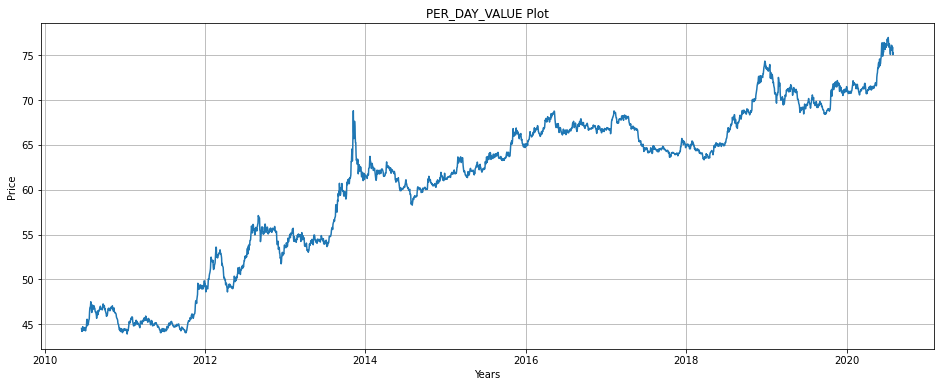

In [0]:
plt.figure(figsize=(16, 6))
plt.plot(2010+((120+time1)/(365-105)),series1)

# The 'time1' variable has the total number of DAYS
# Since the time-series starts from the month of April, hence adding 120 (days) == (3 months), so that our graph plots properly.
# Now, dividing the 'time1' by  365-105: was necessary as the dataset have the value for 5 working days per week, hence we've to remove 2 days per week.
# total week = 52.17 in a year
# total SAT_SUN = 2*52.14 = 104 
# hence our 1 year(365 days) plot is actuaually (365-104 days) plot
# Now the value recieved is 0..1..2...10  (but the year starts from 2010) hence adding 2010 finally!

plt.ylabel('Price')
plt.xlabel('Years')
plt.title('PER_DAY_VALUE Plot')

plt.grid(True,linestyle='-')

plt.show()

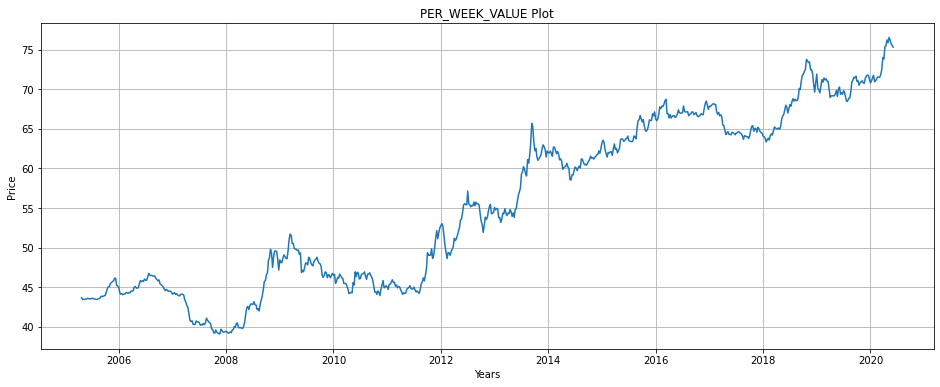

In [0]:
plt.figure(figsize=(16, 6))
plt.plot(2005+((16+time2)/52),series2)

# The 'time2' variable has the total number of WEEKS
# Since the time-series starts from the month of April, hence adding 12 (WEEKS) == (3 MONTHS), so that our graph plots properly. 
# And dividing by 52 weeks per year till now.
# Now the value recieved is 0..1..2...10  (but the year starts from 2010) hence adding 2010 finally!

plt.ylabel('Price')
plt.xlabel('Years')
plt.title('PER_WEEK_VALUE Plot')

plt.grid(True)

plt.show()

Comparing both the graphs we can see that the PER_DAY_VALUE graph is denser than the PER_WEEK_WEEK one. 

So let's WORK on the Time-Series for the PER_DAY_VALUE graph

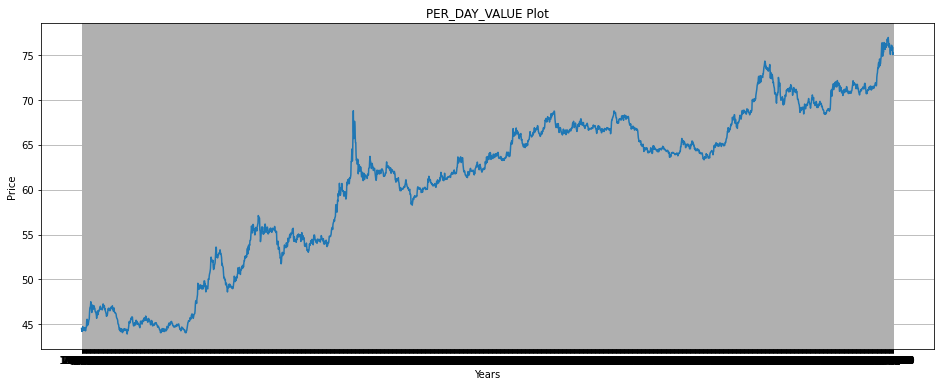

In [0]:
plt.figure(figsize=(16, 6))
plt.plot(df1.Date,series1)

plt.ylabel('Price')
plt.xlabel('Years')
plt.title('PER_DAY_VALUE Plot')
plt.grid(True)
plt.show()

### 4. Preprocessing 
Splitting up the dataset into _TRAIN_ and _VALIDATE_ ,

 Creating the _WINDOW_ for fix input size 

In [0]:
#Since the dataset is 2632 splitting into 2000-632
split_time = 2000
time_train = time1[:split_time]
x_train = series1[:split_time]
time_valid = time1[split_time:]
x_valid = series1[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 500

x_train.shape,x_valid.shape

((2000,), (632,))

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series1, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series1)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series1)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:

tf.random.set_seed(31)
np.random.seed(31)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)


<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.float64, tf.float64)>
(2000,)


### Building Model

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense_9 (Dense)              (None, None, 30)          1950      
_________________________________________________________________
dense_10 (Dense)             (None, None, 10)          310       
_________________________________________________________________
dense_11 (Dense)             (None, None, 1)           11        
_________________________________________________________________
lambda_3 (Lambda)            (None, None, 1)          

In [0]:

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)


In [0]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=50, callbacks=[lr_schedule])


Epoch 1/50


ValueError: ignored

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

NameError: ignored

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150


ValueError: ignored

In [0]:
rnn_forecast = model_forecast(model, series1[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

ValueError: ignored

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

NameError: ignored

<Figure size 720x432 with 0 Axes>

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

NameError: ignored

In [0]:
print(rnn_forecast)

NameError: ignored